In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from urllib import urlretrieve
import cPickle as pickle
import os
import glob
import sys
import gzip

import numpy as np
import theano

from keras.utils import np_utils
import sklearn
import sknn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from PIL import Image
import codecs

import csv
import xlrd

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
# Constants
SIZE = 2084
PATCH_SIZE = 139


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  9 11:32:05 2016

@author: dayong
"""
import numpy as np
from scipy import ndimage as nd
import skimage as ski
import skimage.io as skio
from skimage.exposure import rescale_intensity
from skimage import morphology
import scipy.ndimage.morphology as smorphology
from scipy.ndimage import gaussian_filter
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
#from skimage.filters import gaussian_filter

def nuclei_detect_pipeline(img, MinPixel = 200, MaxPixel=2500):
    sn = stain_normliazation('../nuclei_v1_matlab/StainNormalization/ref.png')
    nimg = sn.stain(img)
    return nimg, nuclei_detection_cancer(nimg, MinPixel, MaxPixel)

def nuclei_detection_cancer(img, MinPixel, MaxPixel, debug = False):
    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    adjustRed[adjustRed < 0.5] = 1
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.8));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.opening(roiMaskNoiseRem, morphology.disk(10));
    cancer_bw = smorphology.binary_fill_holes(roiMaskDilat)

    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.5));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.opening(roiMaskNoiseRem, morphology.disk(5));
    roiMask = smorphology.binary_fill_holes(roiMaskDilat)

    hsv = ski.color.rgb2hsv(img);
    hsv[:,:,2] = 0.8;
    img2 = ski.color.hsv2rgb(hsv)
    diffRGB = img2-img_f
    adjRGB = np.zeros(diffRGB.shape)
    adjRGB[:,:,0] = rescale_intensity(diffRGB[:,:,0],in_range=(0, 0.4))
    adjRGB[:,:,1] = rescale_intensity(diffRGB[:,:,1],in_range=(0, 0.4))
    adjRGB[:,:,2] = rescale_intensity(diffRGB[:,:,2],in_range=(0, 0.4))

    gauss = gaussian_filter(adjRGB[:,:,2], sigma=3, truncate=5.0);

    bw1 = gauss>(100/255.0);
    bw1 = bw1 * roiMask;
    bw1_bwareaopen = morphology.remove_small_objects(bw1, MinPixel)
    bw2 = smorphology.binary_fill_holes(bw1_bwareaopen);

    bwDist = nd.distance_transform_edt(bw2);
    filtDist = gaussian_filter(bwDist,sigma=5, truncate=5.0);

    bw3 = np.logical_or(bw2, cancer_bw)

    L = label(bw3)
    L = clear_border(L)
    R = regionprops(L)
    coutn = 0
    for idx, R_i in enumerate(R):
        #print(idx, R_i['area'], MinPixel, MaxPixel)
        if R_i['area'] > MaxPixel or R_i['area'] < MinPixel:
            L[L==R_i['label']] = 0
        else:
            r, l = R_i['centroid']
            #pass
    BW = L > 0

    if debug:
        plt.figure(1)
        skio.imshow(L)
        plt.show()
    return BW

def nuclei_detection(img, MinPixel, MaxPixel):
    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.5));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.dilation(roiMaskNoiseRem, morphology.disk(3));
    roiMask = smorphology.binary_fill_holes(roiMaskDilat)

    hsv = ski.color.rgb2hsv(img);
    hsv[:,:,2] = 0.8;
    img2 = ski.color.hsv2rgb(hsv)
    diffRGB = img2-img_f
    adjRGB = np.zeros(diffRGB.shape)
    adjRGB[:,:,0] = rescale_intensity(diffRGB[:,:,0],in_range=(0, 0.4))
    adjRGB[:,:,1] = rescale_intensity(diffRGB[:,:,1],in_range=(0, 0.4))
    adjRGB[:,:,2] = rescale_intensity(diffRGB[:,:,2],in_range=(0, 0.4))

    gauss = gaussian_filter(adjRGB[:,:,2], sigma=3, truncate=5.0);

    bw1 = gauss>(100/255.0);
    bw1 = bw1 * roiMask;
    bw1_bwareaopen = morphology.remove_small_objects(bw1, MinPixel)
    bw2 = smorphology.binary_fill_holes(bw1_bwareaopen);

    bwDist = nd.distance_transform_edt(bw2);
    filtDist = gaussian_filter(bwDist,sigma=5, truncate=5.0);

    L = label(bw2)
    R = regionprops(L)
    coutn = 0
    for idx, R_i in enumerate(R):
        if R_i.area < MaxPixel and R_i.area > MinPixel:
            r, l = R_i.centroid
            #print(idx, filtDist[r,l])
        else:
            L[L==(idx+1)] = 0
    BW = L > 0
    return BW

class stain_normliazation:
    def __get_mv_sv(self, img):
        mv,sv = [],[]
        for i in range(3):
            mv.append(np.mean(img[:,:,i]))
            sv.append(np.std(img[:,:,i]))
        return mv, sv
    def __init__(self, ref_name):
        self.img_ref = skio.imread(ref_name)
        self.img_ref_lab = ski.color.rgb2lab(self.img_ref)
        self.mv, self.sv = self.__get_mv_sv(self.img_ref_lab)
        #print self.mv, self.sv
    def stain(self, img):
        img_lab = ski.color.rgb2lab(img)
        mv, sv = self.__get_mv_sv(img_lab)
        #print mv, sv
        for i in range(3):
            img_lab[:,:,i] = ((img_lab[:,:,i] - mv[i]) * (self.sv[i] / sv[i])) + self.mv[i]
        img2 = ski.color.lab2rgb(img_lab)
        if 0:
            plt.subplot(131); skio.imshow(self.img_ref)
            plt.subplot(132); skio.imshow(img)
            plt.subplot(133); skio.imshow(img2)
        img2_ui = ski.img_as_ubyte(img2)
        return img2_ui


None of the detected mitoses seem to overlap with the nuclei regions! See the images below.

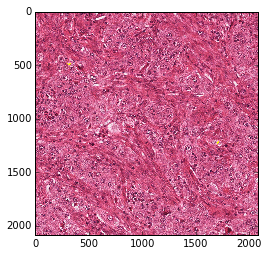

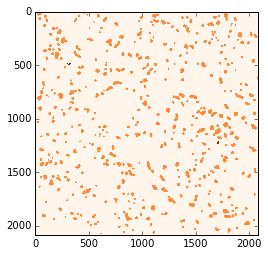

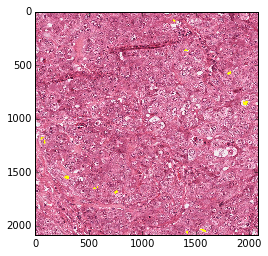

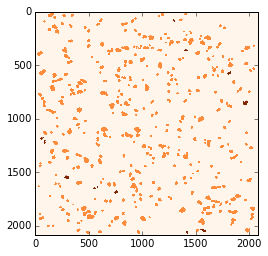

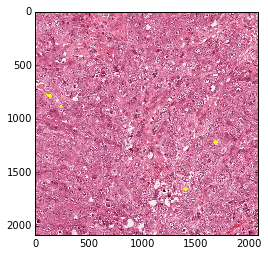

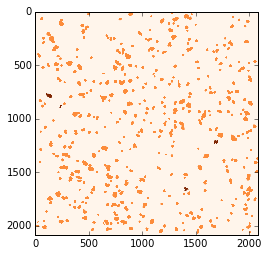

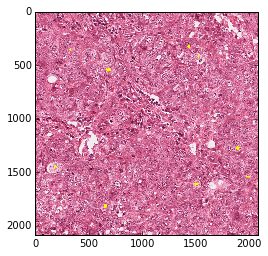

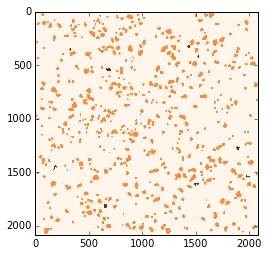

In [14]:
for imgfile in glob.glob("../test/*.bmp")[1:5]:
    img = plt.imread(imgfile)
    nimg, nuclei_map = nuclei_detect_pipeline(img)
    nuclei_map = np.array(nuclei_map).astype(int)
    
    annotfile = imgfile[:-4] + ".csv"
    csvReader = csv.reader(codecs.open(annotfile, 'rU', 'utf-8'))
    
    for row in csvReader:
        for i in range(0, len(row)/2):
            xv, yv = (int(row[2*i]), int(row[2*i+1]))
            nuclei_map[yv, xv] = 2
    
    correctfile = imgfile[:-4] + ".jpg"
    img2 = plt.imread(correctfile)
    
    plt.imshow(img2)
    plt.show()
    
    plt.imshow(nuclei_map, plt.get_cmap("Oranges"))
    plt.show()
    
    
    